# RSV e Influenza

## Librerías

In [3]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import random
import matplotlib.pyplot as plt

## Cargamos los datos

In [4]:
# Cargar datos de influenza y RSV
influenza_data = pd.read_excel('influenza.xlsx')
rsv_data = pd.read_csv('rsv20032009.csv')
print(influenza_data)
print(rsv_data)

# Convertir los datos a arrays de NumPy
influenza_data = np.array(influenza_data['Influenza'])
rsv_data = np.array(rsv_data)

    Year  Epidemiological week  Influenza  Unnamed: 3  Year.1  \
0   2003                     1          0         NaN  2004.0   
1   2003                     2          0         NaN  2004.0   
2   2003                     3          0         NaN  2004.0   
3   2003                     4          0         NaN  2004.0   
4   2003                     5          2         NaN  2004.0   
5   2003                     6          0         NaN  2004.0   
6   2003                     7          2         NaN  2004.0   
7   2003                     8          1         NaN  2004.0   
8   2003                     9          2         NaN  2004.0   
9   2003                    10          2         NaN  2004.0   
10  2003                    11          0         NaN  2004.0   
11  2003                    12          0         NaN  2004.0   
12  2003                    13          2         NaN  2004.0   
13  2003                    14          3         NaN  2004.0   
14  2003                 

c:\Users\lebue\AppData\Local\Programs\Python\Python311\Lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


## Modelo SEIR

In [5]:
# Definir el modelo SEIRS
def seirs_model(y, t, beta1, beta2, gamma1, gamma2, eta1, eta2, mu, theta1, theta2, sigma, N):
    S, E1, I1, R1, E2, I2, R2 = y
    
    # Ecuaciones del modelo SEIRS
    dSdt = mu * N - (beta1 * S * I1 / N + beta2 * S * I2 / N) - mu * S + theta1 * R1 + theta2 * R2
    dE1dt = (beta1 * S * I1 / N) - (mu + gamma1) * E1 - sigma * beta2 * E1 * I2 / N
    dI1dt = gamma1 * E1 - (mu + eta1) * I1 - sigma * beta2 * I1 * I2 / N
    dR1dt = eta1 * I1 - (mu + theta1) * R1 - sigma * beta2 * R1 * I2 / N
    dE2dt = (beta2 * S * I2 / N) + sigma * beta2 * (E1 + I1 + R1) * I2 / N - (mu + gamma2) * E2
    dI2dt = gamma2 * E2 - (mu + eta2) * I2
    dR2dt = eta2 * I2 - (mu + theta2) * R2
    
    return [dSdt, dE1dt, dI1dt, dR1dt, dE2dt, dI2dt, dR2dt]

# Función para simular el modelo en el tiempo
def sim_seirs_time(params, S0, E10, I10, R10, E20, I20, R20, N, time):
    beta1, beta2, gamma1, gamma2, eta1, eta2, mu, theta1, theta2, sigma = params
    y0 = [S0, E10, I10, R10, E20, I20, R20]
    ret = odeint(seirs_model, y0, time, args=(beta1, beta2, gamma1, gamma2, eta1, eta2, mu, theta1, theta2, sigma, N))
    S, E1, I1, R1, E2, I2, R2 = ret.T
    return I1, I2  # Retornamos los infectados de influenza y RSV

## MCMC

In [6]:
# Función de verosimilitud
def likelihood(data1, data2, predicted_cases1, predicted_cases2):
    # Truncar los datos observados a 52 semanas
    data1 = data1[:52]
    data2 = data2[:52]
    
    # Truncar las predicciones a 364 días (52 semanas)
    predicted_cases1 = predicted_cases1[:364]
    predicted_cases2 = predicted_cases2[:364]
    
    # Agregar las predicciones diarias a semanales
    predicted_weekly1 = predicted_cases1.reshape(-1, 7).sum(axis=1)  # Sumar cada 7 días
    predicted_weekly2 = predicted_cases2.reshape(-1, 7).sum(axis=1)  # Sumar cada 7 días
    
    # Calcular la verosimilitud
    sigma1 = np.std(data1)
    sigma2 = np.std(data2)
    log_likelihood1 = -0.5 * np.sum((data1 - predicted_weekly1)**2 / sigma1**2)
    log_likelihood2 = -0.5 * np.sum((data2 - predicted_weekly2)**2 / sigma2**2)
    return log_likelihood1 + log_likelihood2

# MCMC
def mcmc(data1, data2, param_0, iter, time, S0, E10, I10, R10, E20, I20, R20, N):
    # Parámetros iniciales
    beta1, beta2, gamma1, gamma2, eta1, eta2, mu, theta1, theta2, sigma = param_0
    accepted_params = []
    current_likelihood = likelihood(data1, data2, *sim_seirs_time(param_0, S0, E10, I10, R10, E20, I20, R20, N, time))
    
    for i in range(iter):
        # Proponer nuevos parámetros
        new_params = [
            beta1 + random.uniform(-0.01, 0.01),
            beta2 + random.uniform(-0.01, 0.01),
            gamma1 + random.uniform(-0.01, 0.01),
            gamma2 + random.uniform(-0.01, 0.01),
            eta1 + random.uniform(-0.01, 0.01),
            eta2 + random.uniform(-0.01, 0.01),
            mu + random.uniform(-0.001, 0.001),
            theta1 + random.uniform(-0.01, 0.01),
            theta2 + random.uniform(-0.01, 0.01),
            sigma + random.uniform(-0.01, 0.01)
        ]
        
        # Simular el modelo con los nuevos parámetros
        new_predicted1, new_predicted2 = sim_seirs_time(new_params, S0, E10, I10, R10, E20, I20, R20, N, time)
        
        # Calcular la nueva verosimilitud
        new_likelihood = likelihood(data1, data2, new_predicted1, new_predicted2)
        
        # Probabilidad de aceptación
        accept_prob = np.exp(new_likelihood - current_likelihood)
        
        if accept_prob > random.uniform(0, 1):
            # Aceptar nuevos parámetros
            beta1, beta2, gamma1, gamma2, eta1, eta2, mu, theta1, theta2, sigma = new_params
            current_likelihood = new_likelihood
            accepted_params.append(new_params)
    
    return accepted_params

C:\Users\lebue\AppData\Local\Temp\ipykernel_24200\4067317090.py:51: RuntimeWarning: overflow encountered in exp
  accept_prob = np.exp(new_likelihood - current_likelihood)
c:\Users\lebue\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


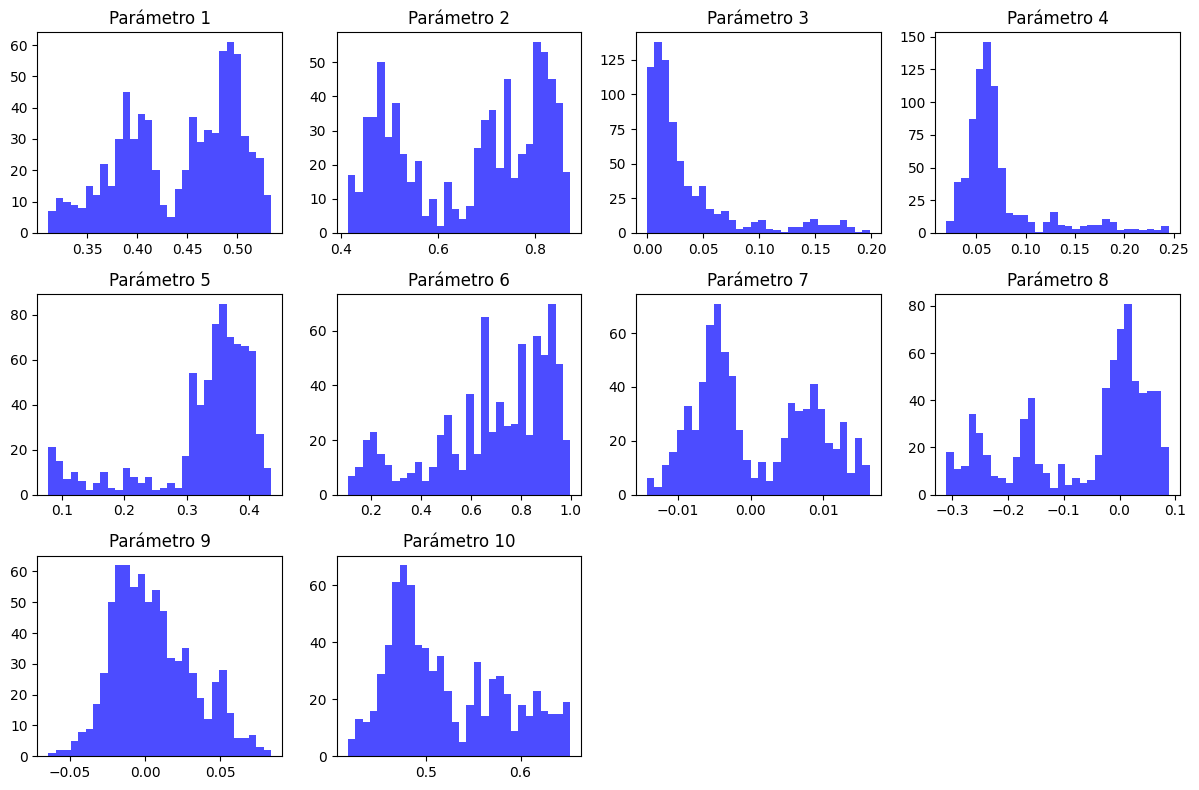

In [7]:
# Parámetros iniciales
param_0 = [0.5, 0.5, 0.2, 0.2, 0.1, 0.1, 0.01, 0.01, 0.01, 0.5]

# Condiciones iniciales
N = 1000000  # Población total
S0 = N - 1   # Susceptibles iniciales
E10, I10, R10 = 0, 1, 0  # Expuestos, infectados y recuperados iniciales de influenza
E20, I20, R20 = 0, 1, 0  # Expuestos, infectados y recuperados iniciales de RSV

# Tiempo de simulación (diario)
time = np.arange(0, 365, 1)  # 1 año de simulación

# Ejecutar MCMC
accepted_params = mcmc(influenza_data, rsv_data, param_0, iter=10000, time=time, S0=S0, E10=E10, I10=I10, R10=R10, E20=E20, I20=I20, R20=R20, N=N)

# Convertir los parámetros aceptados a un array de NumPy
accepted_params = np.array(accepted_params)

# Graficar las distribuciones posteriores de los parámetros
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for i in range(10):
    plt.subplot(3, 4, i+1)
    plt.hist(accepted_params[:, i], bins=30, color='blue', alpha=0.7)
    plt.title(f'Parámetro {i+1}')
plt.tight_layout()
plt.show()

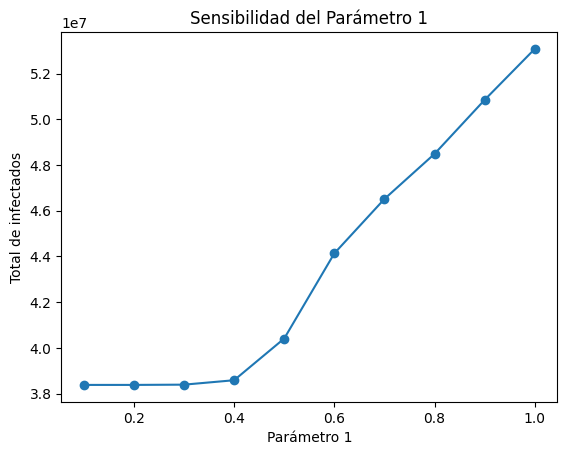

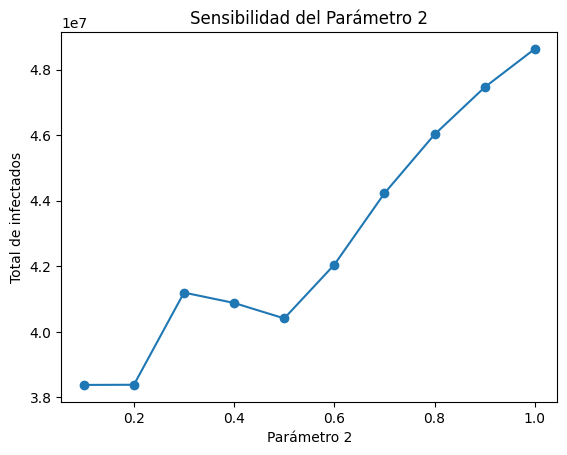

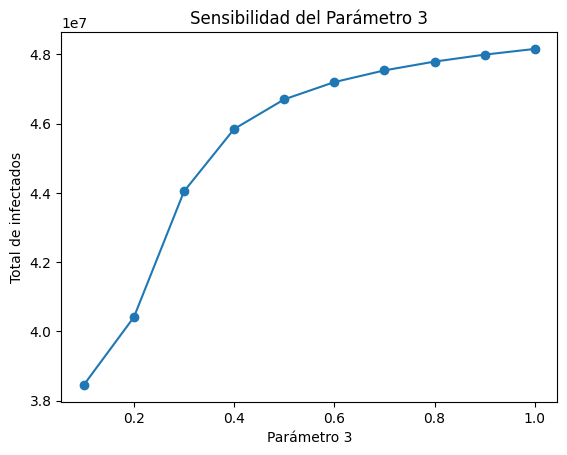

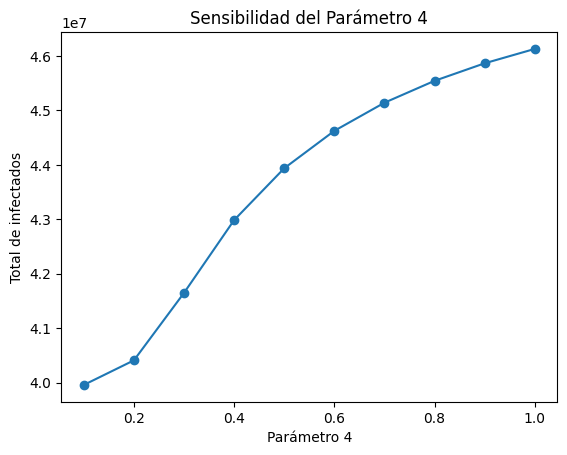

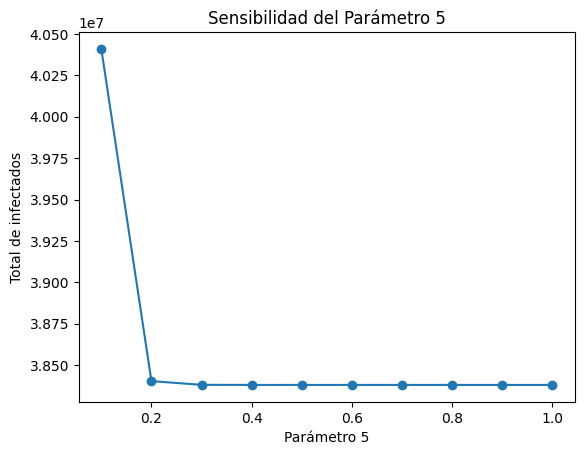

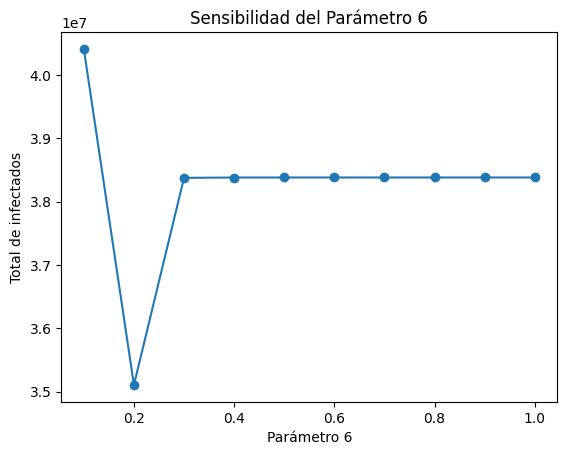

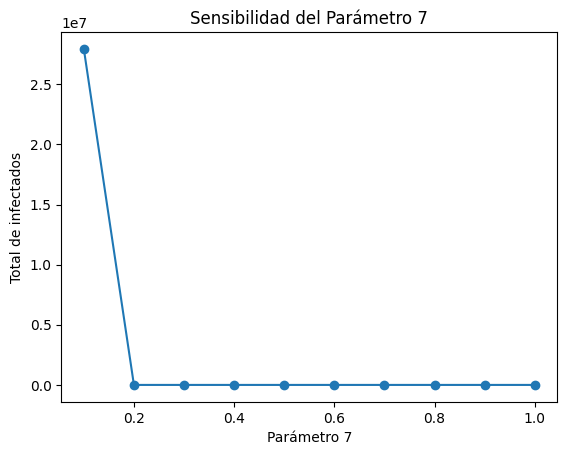

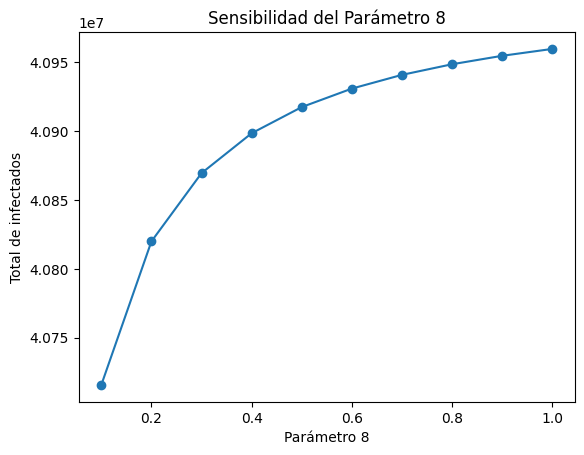

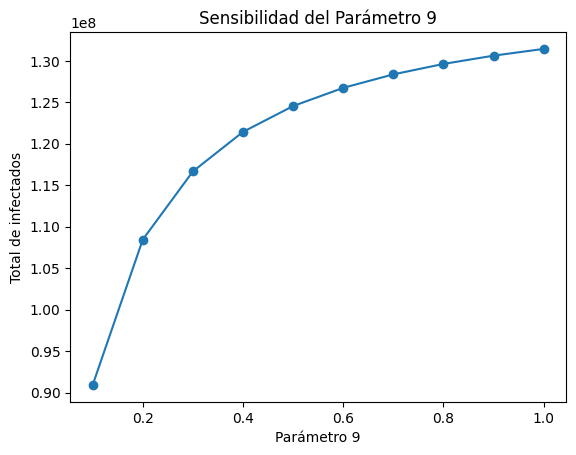

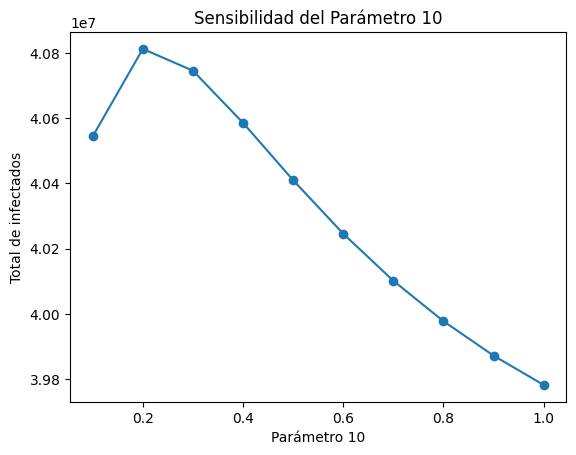

In [8]:
# Función para realizar el análisis de sensibilidad
def sensitivity_analysis(param_index, param_range, params, S0, E10, I10, R10, E20, I20, R20, N, time):
    # Lista para almacenar los resultados
    results = []
    
    # Variar el parámetro en el rango especificado
    for value in param_range:
        # Copiar los parámetros originales
        new_params = params.copy()
        # Cambiar el valor del parámetro de interés
        new_params[param_index] = value
        # Simular el modelo con los nuevos parámetros
        predicted1, predicted2 = sim_seirs_time(new_params, S0, E10, I10, R10, E20, I20, R20, N, time)
        # Almacenar el número total de infectados
        results.append(np.sum(predicted1) + np.sum(predicted2))
    
    # Graficar los resultados
    plt.plot(param_range, results, marker='o')
    plt.xlabel(f'Parámetro {param_index + 1}')
    plt.ylabel('Total de infectados')
    plt.title(f'Sensibilidad del Parámetro {param_index + 1}')
    plt.show()

# Parámetros iniciales
params = [0.5, 0.5, 0.2, 0.2, 0.1, 0.1, 0.01, 0.01, 0.01, 0.5]

# Rango de variación para el análisis de sensibilidad
param_range = np.linspace(0.1, 1.0, 10)  # Por ejemplo, variar entre 0.1 y 1.0

# Realizar el análisis de sensibilidad para cada parámetro
for i in range(10):
    sensitivity_analysis(i, param_range, params, S0, E10, I10, R10, E20, I20, R20, N, time)

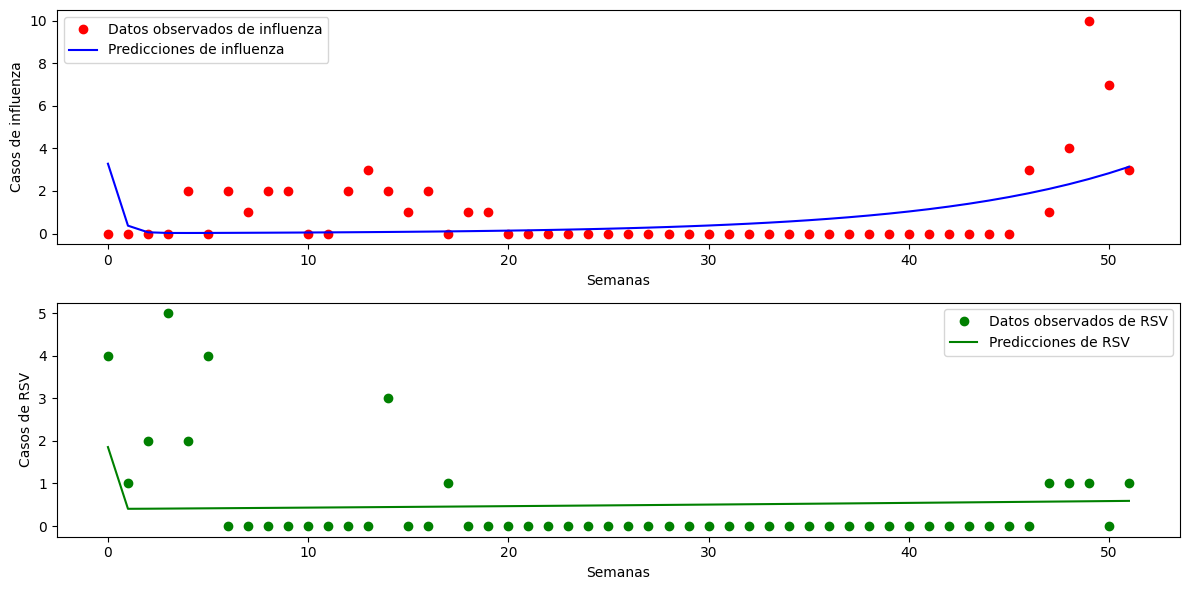

MSE para influenza: 2.75577262311995
MSE para RSV: 1.326799512808559
R² para influenza: 0.19866553684091348
R² para RSV: -52.54725197961707


In [9]:
# Simular el modelo con los parámetros estimados
best_params = accepted_params[-1]  # Usar los últimos parámetros aceptados
predicted1, predicted2 = sim_seirs_time(best_params, S0, E10, I10, R10, E20, I20, R20, N, time)

# Truncar las predicciones a 52 semanas
predicted_weekly1 = predicted1[:364].reshape(-1, 7).sum(axis=1)
predicted_weekly2 = predicted2[:364].reshape(-1, 7).sum(axis=1)

# Graficar los resultados
plt.figure(figsize=(12, 6))

# Graficar influenza
plt.subplot(2, 1, 1)
plt.plot(influenza_data[:52], 'ro', label='Datos observados de influenza')
plt.plot(predicted_weekly1, 'b-', label='Predicciones de influenza')
plt.xlabel('Semanas')
plt.ylabel('Casos de influenza')
plt.legend()

# Graficar RSV
plt.subplot(2, 1, 2)
plt.plot(rsv_data[:52], 'go', label='Datos observados de RSV')
plt.plot(predicted_weekly2, 'g-', label='Predicciones de RSV')
plt.xlabel('Semanas')
plt.ylabel('Casos de RSV')
plt.legend()

plt.tight_layout()
plt.show()

# Calcular el Error Cuadrático Medio (MSE)
mse_influenza = np.mean((influenza_data[:52] - predicted_weekly1)**2)
mse_rsv = np.mean((rsv_data[:52] - predicted_weekly2)**2)

print(f'MSE para influenza: {mse_influenza}')
print(f'MSE para RSV: {mse_rsv}')

# Calcular el Coeficiente de Determinación (R²)
def r_squared(observed, predicted):
    mean_observed = np.mean(observed)
    ss_total = np.sum((observed - mean_observed)**2)
    ss_residual = np.sum((observed - predicted)**2)
    return 1 - (ss_residual / ss_total)

r2_influenza = r_squared(influenza_data[:52], predicted_weekly1)
r2_rsv = r_squared(rsv_data[:52], predicted_weekly2)

print(f'R² para influenza: {r2_influenza}')
print(f'R² para RSV: {r2_rsv}')